In [1]:
   from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install clearml

     |████████████████████████████████| 1.0 MB 8.8 MB/s 


In [ ]:
%%bash

export api=`cat <<EOF
api {
    # Stef Telford's workspace
    web_server: https://app.community.clear.ml
    api_server: https://api.community.clear.ml
    files_server: https://files.community.clear.ml
    credentials {
        "access_key" = "P3HU9EH0MOMZ4Z8WUNT0"
        "secret_key" = "7EaR8xZoHSKNm3HGzcHhCwcWnulmmmDOtLzj0WICVtwXbw5fYZ"
    }
}
EOF
`
echo "$api" > /root/clearml.conf

In [ ]:
from clearml import Task
task = Task.init(project_name="Sign language classification", task_name="my task")

ClearML Task: created new task id=c7d39fc512be4ae3b366c1032e9c7f29
2021-10-09 01:49:22,016 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/ced366729a0b4b60b73286389d741627/experiments/c7d39fc512be4ae3b366c1032e9c7f29/output/log


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
#    Vẽ được các đồ thị bên trong cell của colab
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import ipywidgets as widgets
import io

In [14]:
# Gắn nhãn
labels = ['one', 'two', 'three', 'four', 'five']
X_train=[]
X_test=[]
y_train=[]
y_test=[]
image_size = (150,150)
# Load các label cho các nhãn của data
for label in labels:
    train_path = os.path.join('/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/train', label)
    for file in tqdm(os.listdir(train_path)):
        image = cv2.imread(os.path.join(train_path, file))
        image = cv2.resize(image, (image_size))
        X_train.append(image)
        y_train.append(label)

    test_path = os.path.join('/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/test', label)
    for file in tqdm(os.listdir(test_path)):
        image = cv2.imread(os.path.join(test_path, file))
        image = cv2.resize(image, image_size)
        X_test.append(image)
        y_test.append(label)
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 301/301 [00:01<00:00, 276.70it/s]


(1505, 150, 150, 3)


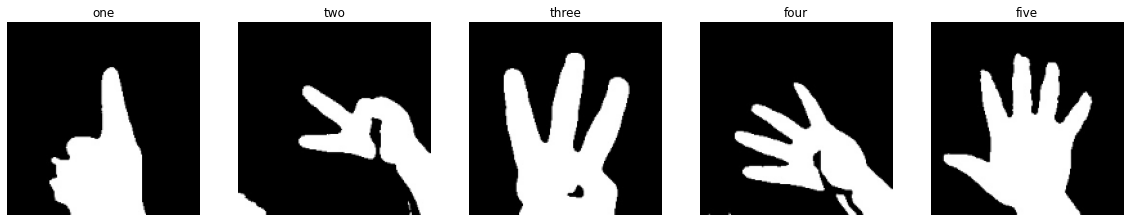

In [15]:
fig, ax = plt.subplots(1,5, figsize=(20,20))
k = 0
for i in range(0,5):
    if i == 0: idx = 0
    elif i == 1: idx = 400
    elif i == 2: idx = 800
    elif i ==3: idx = 1200
    else: idx = 1500
    ax[k].imshow(X_train[idx])
    ax[k].set_title(y_train[idx]) 
    ax[k].axis('off')
    k+=1
print(X_train.shape)

In [16]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_test, y_train, random_state= 28)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


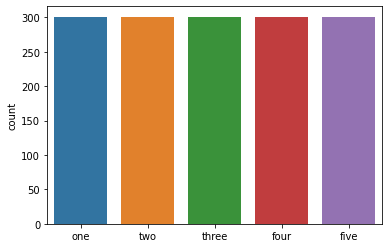

In [17]:
sns.countplot(y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


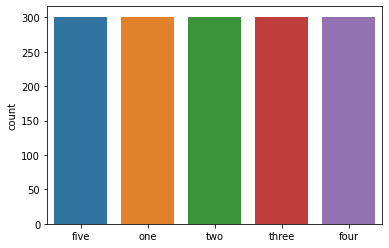

In [18]:
sns.countplot(y_train)

In [20]:
from tensorflow.keras.utils import to_categorical
Y_TRAIN = []
for i in y_train:
    Y_TRAIN.append(labels.index(i))
y_train = Y_TRAIN
y_train = to_categorical(y_train)
Y_TEST = []
for i in y_test:
    Y_TEST.append(labels.index(i))
y_test = Y_TEST
y_test = to_categorical(y_test)


In [21]:
print(X_train)
print(X_train.shape)

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=28)

In [24]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(963, 150, 150, 3)
(241, 150, 150, 3)
(963, 5)
(241, 5)


In [25]:
print(y_train.shape)
print(y_test.shape)

(963, 5)
(1505, 5)


In [26]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58900480/58889256 [==============================] - 0s 0us/step


In [27]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model

In [28]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(5, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs = model)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [30]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=2, verbose=1, min_delta=0.001, mode = 'auto')
tensorboard = TensorBoard(log_dir='/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/logs_3')
checkpoint = ModelCheckpoint('/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/sign_language_classification_3.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose = 1)

In [32]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [33]:
datagen.fit(X_train)

In [34]:
print(X_train.shape)

(963, 150, 150, 3)


In [35]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              validation_data = (X_val, y_val),
                              epochs = 30,
                              verbose =1,
                              callbacks=[tensorboard, checkpoint, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
31/31 [==============================] - 881s 28s/step - loss: 6.8689 - accuracy: 0.2253 - val_loss: 1.7830 - val_accuracy: 0.2033

Epoch 00001: val_accuracy improved from -inf to 0.20332, saving model to /content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/sign_language_classification_3.h5
Epoch 2/30
31/31 [==============================] - 905s 29s/step - loss: 1.5618 - accuracy: 0.2638 - val_loss: 1.8442 - val_accuracy: 0.1784

Epoch 00002: val_accuracy did not improve from 0.20332
Epoch 3/30
31/31 [==============================] - 886s 29s/step - loss: 1.4012 - accuracy: 0.3915 - val_loss: 1.3013 - val_accuracy: 0.3942

Epoch 00003: val_accuracy improved from 0.20332 to 0.39419, saving model to /content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/sign_language_classification_3.h5
Epoch 4/30
31/31 [==============================] - 883s 29s/step - loss: 1.2057 - accuracy: 0.4766 - val_los

In [36]:
model.save('/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/model_sign_language_classification_3.hdf5')

In [ ]:
model = load_model('/content/drive/Shareddrives/Bấu bã mùa dịch/Hùng/ComputerVision/Sign_Languge_Recognition/model_sign_language_classification.hdf5')

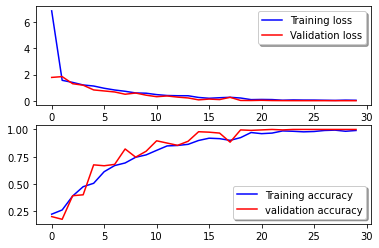

In [37]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color = 'b', label='Training loss')
ax[0].plot(history.history['val_loss'], color = 'r', label='Validation loss', axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow=True)
ax[1].plot(history.history['accuracy'], color = 'b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color = 'r', label='validation accuracy')
legend = ax[1].legend(loc = 'best', shadow=True)

In [38]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


In [39]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 99.87%


In [42]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,image_size)
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]
    if p==0:
        p='one'
    elif p==1:
        p='two'
    elif p==2:
        p = 'three'
    elif p==3:
        p='four'
    elif p == 4:
        p='five'
    else:
        print('Can not dectect your hand!')
    print(p)

In [45]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')